In [1]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:1E.0
All done.


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

from core import *
from torch_backend import *

### Network definitions

In [2]:
def res_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
        'branch': {
            'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
            'bn2': batch_norm(c_out, **kw),
            'relu2': nn.ReLU(True),
            'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        }
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), [rel_path('relu1')])
    block['add'] =  (Add(), [(rel_path('conv3') if projection else rel_path('relu1')), rel_path('branch', 'conv2')])
    return block

def DAWN_net(c=64, block=res_block, prep_bn_relu=False, concat_pool=True, **kw):    
    if isinstance(c, int):
        c = [c, 2*c, 4*c, 4*c]
        
    classifier_pool = {
        'in': Identity(),
        'maxpool': nn.MaxPool2d(4),
        'avgpool': (nn.AvgPool2d(4), [rel_path('in')]),
        'concat': (Concat(), [rel_path('maxpool'), rel_path('avgpool')]),
    } if concat_pool else {'pool': nn.MaxPool2d(4)}
    
    return {
        'prep': union({'conv': nn.Conv2d(3, c[0], kernel_size=3, stride=1, padding=1, bias=False)},
                      {'bn': batch_norm(c[0], **kw), 'relu': nn.ReLU(True)} if prep_bn_relu else {}),
        'layer1': {
            'block0': block(c[0], c[0], 1, **kw),
            'block1': block(c[0], c[0], 1, **kw),
        },
        'layer2': {
            'block0': block(c[0], c[1], 2, **kw),
            'block1': block(c[1], c[1], 1, **kw),
        },
        'layer3': {
            'block0': block(c[1], c[2], 2, **kw),
            'block1': block(c[2], c[2], 1, **kw),
        },
        'layer4': {
            'block0': block(c[2], c[3], 2, **kw),
            'block1': block(c[3], c[3], 1, **kw),
        },
        'final': union(classifier_pool, {
            'flatten': Flatten(),
            'linear': nn.Linear(2*c[3] if concat_pool else c[3], 10, bias=True),
        }),
        'classifier': Identity(),
    }


def conv_bn(c_in, c_out, bn_weight_init=1.0, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'relu': nn.ReLU(True)
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'classifier': Mul(weight),
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    residual = lambda c, **kw: {'in': Identity(), 'res1': conv_bn(c, c, **kw), 'res2': conv_bn(c, c, **kw), 
                                'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')])}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n


losses = {
    'loss':  (nn.CrossEntropyLoss(reduce=False), [('classifier',), ('target',)]),
    'correct': (Correct(), [('classifier',), ('target',)]),
}

remove_identity_nodes = lambda net: remove_by_type(net, Identity)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


### Download and preprocess data

In [3]:
DATA_DIR = './data'
dataset = cifar10(DATA_DIR)
t = Timer()
print('Preprocessing training data')
train_set = list(zip(transpose(normalise(pad(dataset['train']['data'], 4))), dataset['train']['labels']))
print(f'Finished in {t():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(transpose(normalise(dataset['test']['data'])), dataset['test']['labels']))
print(f'Finished in {t():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 3.1 seconds
Preprocessing test data
Finished in 0.14 seconds


### Training loop

In [12]:
def train(model, lr_schedule, optimizer, train_set, test_set, batch_size, num_workers=0):
    train_batches = Batches(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
    test_batches = Batches(test_set, batch_size, shuffle=False, num_workers=num_workers)
    optimizer.opt_params['lr'] = lambda step: lr_schedule(step/len(train_batches))/batch_size
    table, timer = TableLogger(), Timer()
    for epoch in range(lr_schedule.knots[-1]):
        epoch_stats = train_epoch(model, train_batches, test_batches, optimizer.step, timer, test_time_in_total=True) 
        summary = union({'epoch': epoch+1, 'lr': lr_schedule(epoch+1)}, epoch_stats)
        table.append(summary)
    return summary

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - DAWNbench baseline + no initial bn-relu+ efficient dataloading/augmentation, 1 dataloader process (301s)

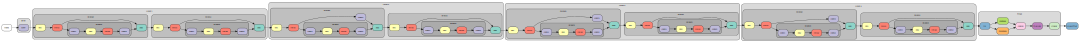

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0067       6.8526       1.6560       0.3829       0.4870       1.3605       0.5198       7.3396
           2       0.0133       6.7992       1.0044       0.6424       0.4867       0.8560       0.7007      14.6254
           3       0.0200       6.7301       0.7538       0.7354       0.4526       0.7101       0.7552      21.8081
           4       0.0267       6.7953       0.6382       0.7780       0.4643       0.5976       0.8000      29.0677
           5       0.0333       6.7002       0.5669       0.8043       0.4491       0.7872       0.7472      36.2170
           6       0.0400       6.6877       0.5093       0.8242       0.4683       0.5423       0.8148      43.3730
           7       0.0467       6.6392       0.4694       0.8400       0.4509       0.5086       0.8232      50.4631
           8       0.0533       6.8832       0.4376       0.8495

In [14]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=1)

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - 0 dataloader processes (297s)

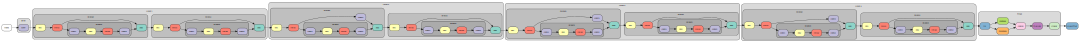

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0067       6.4659       1.6659       0.3804       0.3767       1.3605       0.5140       6.8426
           2       0.0133       6.4757       1.0084       0.6408       0.3797       1.1952       0.6052      13.6980
           3       0.0200       6.4757       0.7493       0.7383       0.3840       0.7589       0.7436      20.5577
           4       0.0267       6.4743       0.6337       0.7812       0.3771       0.6412       0.7846      27.4091
           5       0.0333       6.4726       0.5574       0.8073       0.3969       0.5612       0.8079      34.2787
           6       0.0400       6.5163       0.5057       0.8265       0.4004       0.5388       0.8207      41.1955
           7       0.0467       6.4917       0.4703       0.8377       0.3832       0.5971       0.7942      48.0704
           8       0.0533       6.4733       0.4313       0.8520

In [15]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size,  num_workers=0)

### [Post 2: Mini-batches](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_2/) - batch size=512 (256s)

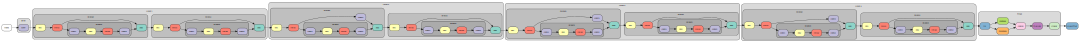

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0293       6.8122       1.7308       0.3570       0.4718       1.5902       0.4596       7.2841
           2       0.0587       5.0096       1.0917       0.6081       0.3060       1.1059       0.6337      12.5997
           3       0.0880       5.0059       0.7787       0.7243       0.3059       0.7754       0.7316      17.9115
           4       0.1173       5.0505       0.6408       0.7758       0.3051       0.7841       0.7406      23.2671
           5       0.1467       5.0028       0.5503       0.8097       0.3053       0.6362       0.7835      28.5752
           6       0.1760       5.0016       0.4945       0.8294       0.3065       0.5512       0.8100      33.8833
           7       0.2053       5.0035       0.4530       0.8440       0.3052       0.5276       0.8175      39.1920
           8       0.2347       5.0277       0.4158       0.8562

In [16]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - speed up batch norms (186s)

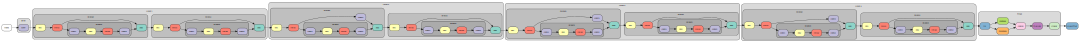

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0293       4.4231       1.7187       0.3601       0.3057       1.2499       0.5484       4.7288
           2       0.0587       4.4285       1.0809       0.6089       0.3075       1.2263       0.6002       9.4648
           3       0.0880       4.4296       0.7759       0.7262       0.3065       0.8122       0.7257      14.2008
           4       0.1173       4.4305       0.6356       0.7760       0.3067       0.7249       0.7537      18.9380
           5       0.1467       4.4762       0.5627       0.8032       0.3065       0.8471       0.7234      23.7208
           6       0.1760       4.4272       0.4928       0.8311       0.3057       0.6922       0.7658      28.4537
           7       0.2053       4.4273       0.4557       0.8422       0.3058       0.5797       0.8057      33.1868
           8       0.2347       4.4266       0.4255       0.8520

In [17]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - cutout+30 epochs+batch_size=512 (161s)

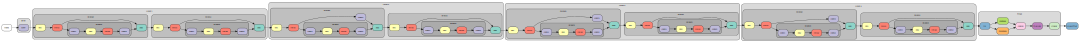

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0500       4.4296       1.7153       0.3614       0.3681       1.2575       0.5486       4.7976
           2       0.1000       4.4320       1.1202       0.5958       0.3055       1.8857       0.4832       9.5352
           3       0.1500       4.4300       0.8650       0.6948       0.3056       0.9143       0.6849      14.2708
           4       0.2000       4.4295       0.7227       0.7451       0.3050       0.6717       0.7688      19.0053
           5       0.2500       4.4632       0.6316       0.7794       0.3059       0.7078       0.7486      23.7744
           6       0.3000       4.4235       0.5784       0.8000       0.3058       0.8209       0.7257      28.5037
           7       0.3500       4.4219       0.5486       0.8085       0.3052       0.6884       0.7639      33.2309
           8       0.4000       4.4210       0.5306       0.8156

In [18]:
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.4, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/)  - batch_size=768 (154s)

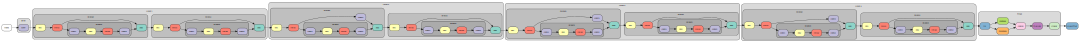

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0750       5.8285       1.7852       0.3372       0.2924       2.1064       0.3740       6.1209
           2       0.1500       4.3309       1.2310       0.5556       0.2903       1.5450       0.5099      10.7422
           3       0.2250       4.3070       0.9326       0.6697       0.2909       1.2673       0.5853      15.3401
           4       0.3000       4.3083       0.7545       0.7347       0.2922       0.7737       0.7294      19.9407
           5       0.3750       4.3424       0.6411       0.7763       0.2922       0.8359       0.7106      24.5753
           6       0.4500       4.3339       0.5808       0.7990       0.2903       0.9704       0.6815      29.1995
           7       0.5250       4.2997       0.5486       0.8101       0.2891       0.9453       0.7033      33.7883
           8       0.6000       4.2997       0.5295       0.8182

In [19]:
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.6, 0])
batch_size = 768

n = DAWN_net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone (36s; test acc 55.9%)

It seems reasonable to study how the shortest path through the network trains in isolation and to take steps to improve this before adding back the longer branches. 
Eliminating the long branches yields the following backbone network in which all convolutions, except for the initial one, have a stride of two.

Training the shortest path network for 20 epochs yields an unimpressive test accuracy of 55.9% in 36 seconds.

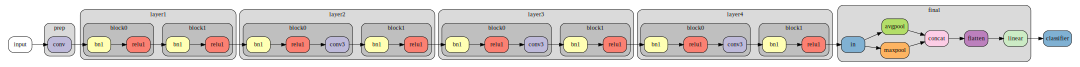

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       1.8775       1.9952       0.2584       0.1548       1.7645       0.3561       2.0323
           2       0.2000       1.8689       1.7656       0.3524       0.1450       1.6898       0.3839       4.0462
           3       0.3000       1.8307       1.6943       0.3821       0.1550       1.6774       0.3876       6.0319
           4       0.4000       1.8995       1.6663       0.3929       0.1440       1.5992       0.4225       8.0755
           5       0.3750       1.7525       1.6494       0.4032       0.1564       1.5825       0.4284       9.9843
           6       0.3500       1.8375       1.6126       0.4125       0.1465       1.5598       0.4356      11.9684
           7       0.3250       1.7787       1.5944       0.4254       0.1567       1.6138       0.4260      13.9037
           8       0.3000       1.9086       1.5611       0.4361

In [20]:
def shortcut_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), [rel_path('relu1')])
    return block

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block)
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, remove repeat bn-relu (32s; test acc 56.0%)

Removing the repeated batch norm-ReLU groups, reduces training time to 32s and leaves test accuracy approximately unchanged.

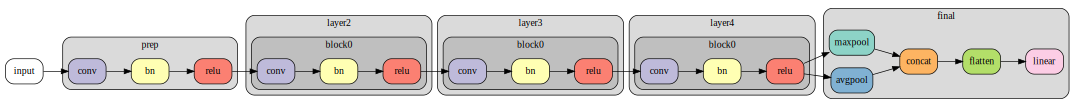

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.0275       1.9549       0.2788       0.1974       1.7310       0.3777       2.2249
           2       0.2000       1.6905       1.7492       0.3624       0.1465       1.6506       0.3997       4.0619
           3       0.3000       1.6741       1.6697       0.3913       0.1418       1.6870       0.3864       5.8779
           4       0.4000       1.7245       1.6648       0.3987       0.1441       1.6405       0.4068       7.7464
           5       0.3750       1.5438       1.6470       0.4054       0.1373       1.5562       0.4478       9.4275
           6       0.3500       1.5782       1.6121       0.4199       0.1462       1.5877       0.4286      11.1519
           7       0.3250       1.6797       1.5869       0.4275       0.1476       1.5179       0.4499      12.9793
           8       0.3000       1.7134       1.5592       0.4379

In [5]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv':  nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 3x3 convs (36s; test acc 85.6%)

A serious shortcoming of this network is that the downsampling convolutions have 1x1 kernels and a stride of two, so that rather than enlarging the receptive field they are simply discarding information. 

If we replace these with 3x3 convolutions, things improve considerably and test accuracy after 20 epochs is 85.6% in a time of 36s.

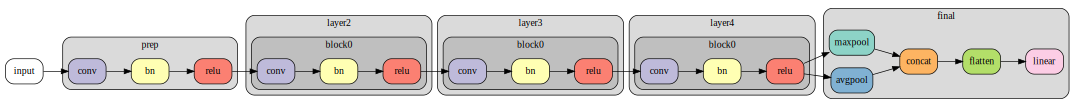

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.0508       1.7308       0.3705       0.1861       1.3731       0.4903       2.2369
           2       0.2000       1.5441       1.3386       0.5154       0.1478       1.1711       0.5787       3.9288
           3       0.3000       1.7685       1.1407       0.5904       0.1450       1.0622       0.6204       5.8424
           4       0.4000       1.6975       1.0908       0.6144       0.1506       1.0718       0.6245       7.6905
           5       0.3750       1.7146       1.0078       0.6450       0.1492       0.9757       0.6593       9.5543
           6       0.3500       1.6656       0.9080       0.6802       0.1534       0.8884       0.6895      11.3733
           7       0.3250       1.7620       0.8637       0.6964       0.1456       0.9482       0.6865      13.2808
           8       0.3000       1.5897       0.7945       0.7212

In [6]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, maxpool downsampling (43s; test acc 89.7%)

We can further improve the downsampling stages by applying 3x3 convolutions of stride one followed by a pooling layer instead of using strided convolutions. 

We choose max pooling with a 2x2 window size leading to a final test accuracy of 89.7% after 43s. Using average pooling gives a similar result but takes slightly longer.

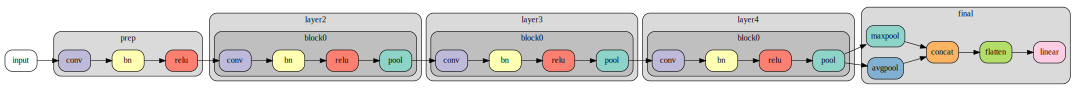

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       3.0536       1.6871       0.3949       0.2558       1.3948       0.5405       3.3093
           2       0.2000       1.8671       1.1606       0.5894       0.1508       0.9039       0.6839       5.3273
           3       0.3000       1.9303       0.9527       0.6686       0.1573       1.0704       0.6257       7.4150
           4       0.4000       1.8663       0.8934       0.6901       0.1485       0.8327       0.7113       9.4297
           5       0.3750       1.8682       0.8073       0.7195       0.1412       0.7715       0.7316      11.4391
           6       0.3500       1.8614       0.7249       0.7520       0.1484       0.6337       0.7838      13.4489
           7       0.3250       1.9188       0.6648       0.7700       0.1519       0.7069       0.7600      15.5196
           8       0.3000       1.8644       0.6291       0.7826

In [7]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 2x output dim, global maxpool (47s; test acc 90.7%)

The final pooling layer before the classifier is a concatenation of global average pooling and max pooling layers, inherited from the original network. 

We replace this with a more standard global max pooling layer and double the output dimension of the final convolution to compensate for the reduction in input dimension to the classifier, leading to a final test accuracy of 90.7% in 47s. Note that average pooling at this stage underperforms max pooling significantly.


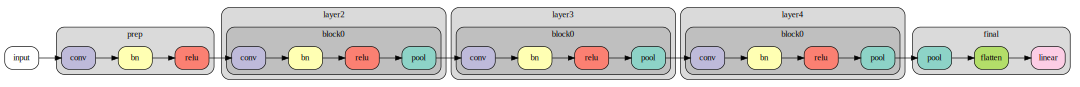

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.4832       1.8201       0.3688       0.2066       1.3938       0.5079       2.6898
           2       0.2000       2.0672       1.2519       0.5615       0.2158       1.0516       0.6293       4.9728
           3       0.3000       2.0645       0.9693       0.6614       0.1586       0.7822       0.7311       7.1959
           4       0.4000       2.0617       0.9380       0.6799       0.1542       1.3522       0.5797       9.4118
           5       0.3750       2.0584       0.8116       0.7226       0.1445       0.7060       0.7579      11.6147
           6       0.3500       2.0564       0.7125       0.7547       0.2066       0.6966       0.7664      13.8777
           7       0.3250       2.0605       0.6593       0.7730       0.1547       0.6893       0.7631      16.0929
           8       0.3000       2.0591       0.6182       0.7878

In [8]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(c=[64,128,256,512], block=shortcut_block, prep_bn_relu=True, concat_pool=False)
display(DotGraph(remove_identity_nodes(n)))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, bn scale init=1, classifier weight=0.125 (47s; test acc 91.1%)

By default in PyTorch (0.4), initial batch norm scales are chosen uniformly at random from the interval [0,1]. Channels which are initialised near zero could be wasted so we replace this with a constant initialisation at 1. 
This leads to a larger signal through the network and to compensate we introduce an overall constant multiplicative rescaling of the final classifier. A rough manual optimisation of this extra hyperparameter suggest that 0.125 is a reasonable value. 
(The low value makes predictions less certain and appears to ease optimisation.) 

With these changes in place, 20 epoch training reaches a test accuracy of 91.1% in 47s. 

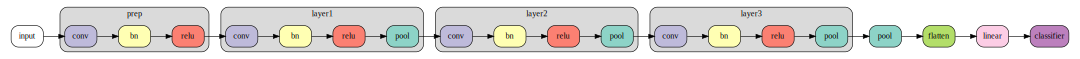

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.0612       1.7973       0.3648       0.1531       1.2866       0.5386       2.2143
           2       0.2000       2.1240       1.1342       0.5999       0.1456       0.9052       0.6766       4.4839
           3       0.3000       2.0614       0.8749       0.6971       0.1443       0.8934       0.6953       6.6896
           4       0.4000       2.0633       0.7480       0.7435       0.1631       0.7204       0.7483       8.9161
           5       0.3750       2.0654       0.6618       0.7746       0.1521       0.6767       0.7770      11.1336
           6       0.3500       2.0963       0.5849       0.8033       0.1444       0.6356       0.7864      13.3742
           7       0.3250       2.0576       0.5370       0.8225       0.1535       0.5014       0.8319      15.5853
           8       0.3000       2.0629       0.5013       0.8329

In [9]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net(extra_layers=(), res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - double width, 60 epoch train! (321s; test acc 93.5%)

ne approach that doesn't seem particularly promising is to just add width. 

If we double the channel dimensions and train for 60 epochs we can reach 93.5% test accuracy with a 5 layer network. This is nice but not efficient since training now takes 321s.

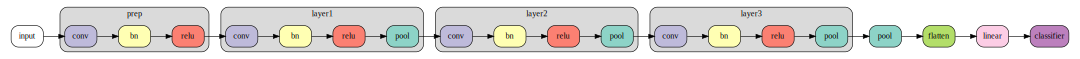

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       9.6687       1.8879       0.3291       0.7929       1.6214       0.4464      10.4616
           2       0.0667       5.3167       1.2460       0.5628       0.3784       1.0503       0.6263      16.1567
           3       0.1000       5.3180       0.9350       0.6807       0.3807       0.7622       0.7368      21.8554
           4       0.1333       5.3191       0.7673       0.7385       0.3788       0.7431       0.7427      27.5533
           5       0.1667       5.3328       0.6730       0.7719       0.3793       0.7541       0.7432      33.2654
           6       0.2000       5.3204       0.6109       0.7939       0.3790       0.5805       0.8037      38.9648
           7       0.2333       5.3206       0.5681       0.8102       0.3781       0.5228       0.8300      44.6635
           8       0.2667       5.3186       0.5294       0.8226

In [10]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
c = 128

n = net(channels={'prep': c, 'layer1': 2*c, 'layer2': 4*c, 'layer3': 8*c}, extra_layers=(), res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8, 8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - extra:L1+L2+L3 network, 60 epochs, cutout=12 (180s, 95.0% test acc) 

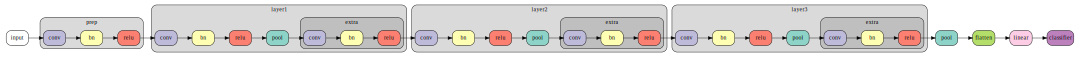

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       3.4445       1.8571       0.3390       0.2635       1.6723       0.4054       3.7080
           2       0.0667       2.6818       1.1796       0.5765       0.1940       0.9478       0.6556       6.5838
           3       0.1000       2.7352       0.8991       0.6836       0.1946       1.2571       0.6007       9.5136
           4       0.1333       2.6792       0.7638       0.7338       0.1938       0.6789       0.7684      12.3865
           5       0.1667       2.6790       0.6880       0.7593       0.1942       0.6666       0.7731      15.2597
           6       0.2000       2.6813       0.6320       0.7809       0.1942       0.6575       0.7732      18.1352
           7       0.2333       2.7264       0.5933       0.7934       0.1947       0.7307       0.7545      21.0562
           8       0.2667       2.6791       0.5655       0.8046

In [13]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
cutout=12

n = net(extra_layers=['layer1', 'layer2', 'layer3'], res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(cutout, cutout)])
summary = train(model, lr_schedule, opt, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network Residual:L1+L3, 20 epochs (66s; test acc 93.7%)

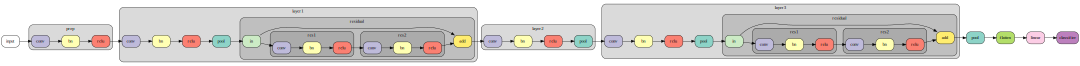

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.9605       1.5841       0.4281       0.2195       1.1686       0.5865       3.1801
           2       0.2000       2.9629       0.9454       0.6631       0.2759       0.8585       0.7054       6.4188
           3       0.3000       2.9642       0.7213       0.7491       0.2190       0.7146       0.7409       9.6020
           4       0.4000       2.9646       0.6209       0.7841       0.2186       0.8419       0.7226      12.7852
           5       0.3750       2.9637       0.5321       0.8178       0.2186       0.5625       0.8072      15.9675
           6       0.3500       2.9598       0.4671       0.8410       0.2688       0.6967       0.7550      19.1960
           7       0.3250       2.9616       0.4235       0.8552       0.2188       0.7235       0.7547      22.3765
           8       0.3000       2.9597       0.3848       0.8694

In [14]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, opt, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network, 24 epochs (79s; test acc 94.1%)

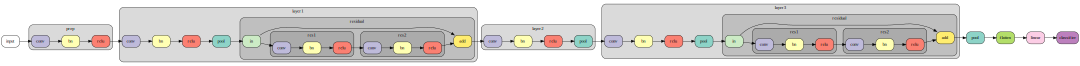

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0800       2.9545       1.6042       0.4199       0.2184       1.1629       0.5758       3.1729
           2       0.1600       2.9604       0.9170       0.6724       0.2195       0.9615       0.6635       6.3529
           3       0.2400       3.0128       0.7207       0.7483       0.2183       0.7565       0.7382       9.5839
           4       0.3200       2.9565       0.6183       0.7838       0.2188       1.1623       0.6477      12.7593
           5       0.4000       2.9525       0.5530       0.8088       0.2182       1.0094       0.6839      15.9300
           6       0.3789       2.9570       0.4969       0.8286       0.2180       0.5447       0.8138      19.1050
           7       0.3579       2.9556       0.4450       0.8492       0.2656       0.7271       0.7555      22.3261
           8       0.3368       2.9508       0.4059       0.8614

In [16]:
lr_schedule = PiecewiseLinear([0, 5, 24], [0, 0.4, 0])
batch_size = 512

n = net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, opt, train_set_x, test_set, batch_size=batch_size, num_workers=0)